In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import randn, seed
from scipy.optimize import minimize
import seaborn as sns

In [2]:
import numpy as np

def loss_surface(model_parameters, target_weights, target_ix, model, y):
    """
    Function to return the cost surface between two chosen weights
    in a model and its L2 loss surface.
    
    Parameters
    ----------
    model_parameters: tuple containing the parameters to compute the model
    target_weights: tuple of lenght 2 containing the parameters compute the loss
    target_ix: typle of lenght 2 containing the indices for each parameter to
               compute the loss
    model: function with parameters "model_parameters" used to compute the output of
           the model
    y: vector with m model outputs
    
    Returns
    -------
    tuppple with grid containing the surface along the chosen parameters
    """
    # target weights
    tweight1, tweight2 = target_weights
    # target indices
    tix1, tix2 = target_ix
    
    # Grid surface for target weights to plot
    tw1, tw2 = np.mgrid[-5:5:0.1, -5:5:0.1]
    # Initialize cost surface
    J = np.zeros_like(tw1.ravel())
    
    for ix, (tw1i, tw2i) in enumerate(zip(tw1.ravel(), tw2.ravel())):
        tweight1[tix1] = tw1i
        tweight2[tix2] = tw2i
        yhat = model(*model_parameters)
        # Updating cost function
        try:
            J[ix] =  np.sum((yhat - y) ** 2) / 2
        except Exception:
            print(ix)
        
    J = J.reshape(*tw1.shape)
    return tw1, tw2, J

In [3]:
%config InlineBackend.figure_format = "retina"

In [4]:
market=pd.read_excel("Prueba.xlsx",index_col=0)

In [5]:
market.columns=[c.replace(" MF Equity", "").replace(" INDEX","") for c in market.columns]
market

,KIMBERA,GAPB,CEMEXCPO,ASURB,GFNORTEO,KOFUBL,AC*,LABB,FEMSAUBD,OMAB,...,MEGACPO,GCC*,BIMBOA,GMEXICOB,GCARSOA1,TLEVICPO,ALFAA,BSMXB,PINFRA*,MEXBOL
DATE,,,,,,,,,,,,,,,,,,,,,
2016-01-01,40.37,152.05,8.72,243.89,94.99,123.90,104.68,13.85,161.63,83.61,...,64.19,44.81,45.95,36.79,70.98,94.34,34.10,30.25,202.73,42977.50
2016-01-04,39.16,148.57,8.43,238.29,91.79,120.29,102.09,14.41,157.62,81.77,...,64.45,43.51,45.02,35.71,69.83,92.62,33.74,29.46,202.93,42113.70
2016-01-05,38.89,147.93,8.31,233.03,91.72,118.82,101.12,13.77,157.80,81.58,...,63.16,43.51,45.77,36.45,70.70,91.89,33.99,29.72,203.56,42041.68
2016-01-06,39.13,146.99,8.29,231.97,91.63,120.32,102.50,13.65,156.37,82.03,...,63.27,43.51,45.97,35.57,70.47,90.41,33.65,29.67,199.80,41691.19
2016-01-07,39.16,141.32,7.64,230.71,89.54,120.20,101.16,13.25,155.14,80.94,...,62.78,42.76,46.18,35.01,68.15,90.23,31.46,28.50,196.75,40661.57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-30,38.50,225.87,7.16,354.06,105.00,114.88,102.63,18.58,179.27,141.14,...,77.22,101.53,34.88,51.89,69.80,44.23,16.00,25.72,193.51,43657.48
2019-12-31,37.50,224.67,7.08,354.04,105.65,114.88,99.98,18.71,178.67,141.83,...,77.44,100.86,34.43,51.86,69.82,44.37,15.68,25.83,193.54,43541.02
2020-01-01,37.50,224.67,7.08,354.04,105.65,114.88,99.98,18.71,178.67,141.83,...,77.44,100.86,34.43,51.86,69.82,44.37,15.68,25.83,193.54,43541.02


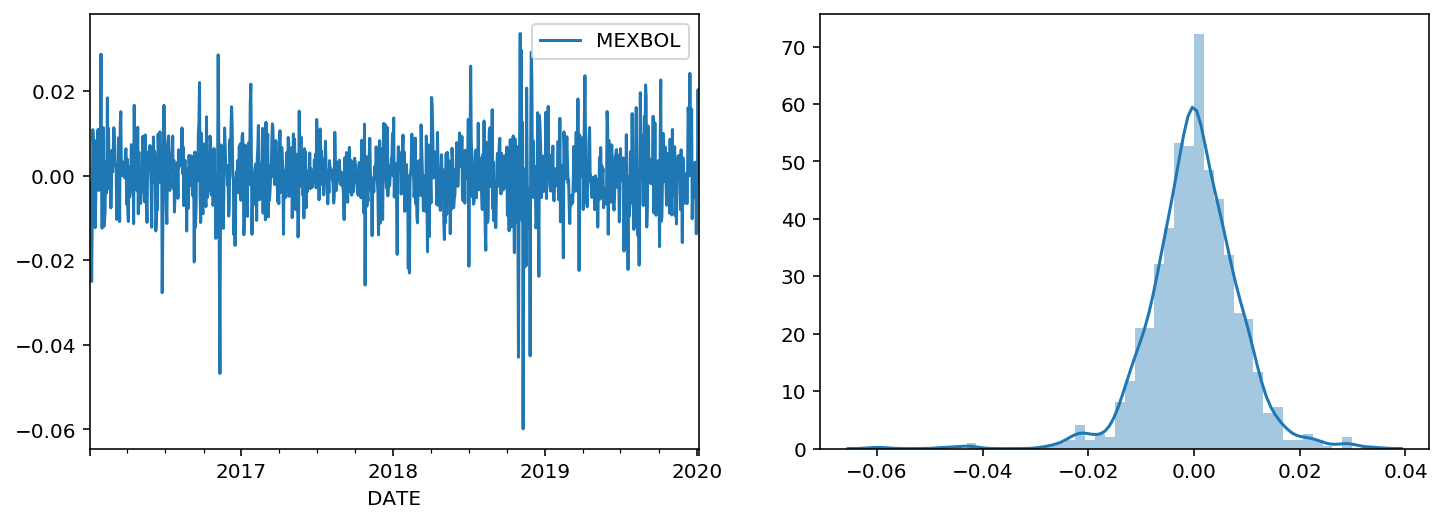

In [6]:
R=market[["MEXBOL"]]
R=np.log(R).diff().dropna()
fig, ax=plt.subplots(1,2, figsize=(12,4))
R.plot(ax=ax[0])
sns.distplot(R,ax=ax[1])

In [7]:
class GARCHSigmas:
    """
    Clase para estimar sigmas para un GARCH(1, 1)
    """
    def __init__(self, omega, alpha, beta, sigma_init, R):
        self.omega = omega
        self.alpha = alpha
        self.beta = beta
        self.R = R
        self.sigma_hist = [sigma_init]
        self.initialize_sigmas()
        
    def get_sigma1(self, t):
        rt0 = 0 if t == 0 else self.R.iloc[t - 1, 0]
        sigma0 = self.sigma_hist[-1]
        sigma1 = self.omega + self.alpha * rt0 ** 2 + self.beta * sigma0
        self.sigma_hist.append(sigma1)
    
    def initialize_sigmas(self):
        N, M = self.R.shape
        for t in range(N - 1, -1, -1):
            self.get_sigma1(t)

In [8]:
def LGarch(omega, alpha, beta, sigma_init, R):
    s=GARCHSigmas(omega, alpha, beta, sigma_init, R)
    sigma_hist=np.array(s.sigma_hist[1:])
    r1_2 =R.values.ravel()**2
    log_likelihood=(np.log(sigma_hist)+r1_2/sigma_hist).sum()/2
    return log_likelihood

In [9]:
R.values

array([[-0.02030362],
       [-0.0017116 ],
       [-0.00837167],
       ...,
       [ 0.        ],
       [ 0.02037415],
       [ 0.00421347]])

In [10]:
seed(314)

omega, alpha, beta = np.abs(randn(3))
sigma_init=R.var(ddof=1).item()/252
LGarch(omega, alpha, beta, sigma_init, R)

/Users/danielpoblano/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: `item` has been deprecated and will be removed in a future version
  after removing the cwd from sys.path.


57.23125325842286

In [11]:
x0=np.array([omega,alpha,beta])
L_part=lambda x0: LGarch(*x0,sigma_init,R)

def cons(x):
    return x[1]+x[2]-1
bounds=[
    (0,None),
    (0,None),
    (0,None)
]
fmin=minimize(L_part, x0, constraints={"type":"ineq","fun":cons},bounds=bounds)

/Users/danielpoblano/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/Users/danielpoblano/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/Users/danielpoblano/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/Users/danielpoblano/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in add
  """


In [12]:
omega_garch, alpha_garch, beta_garch=fmin.x

In [13]:
# Estimar volatilidades

sigma0=sigma_init
garch_predict=[]
for i in range(len(R)):
    sigma0=omega_garch+alpha_garch*R.iloc[i].item()**2+beta_garch*sigma0
    garch_predict.append(sigma0)

/Users/danielpoblano/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: `item` has been deprecated and will be removed in a future version
  


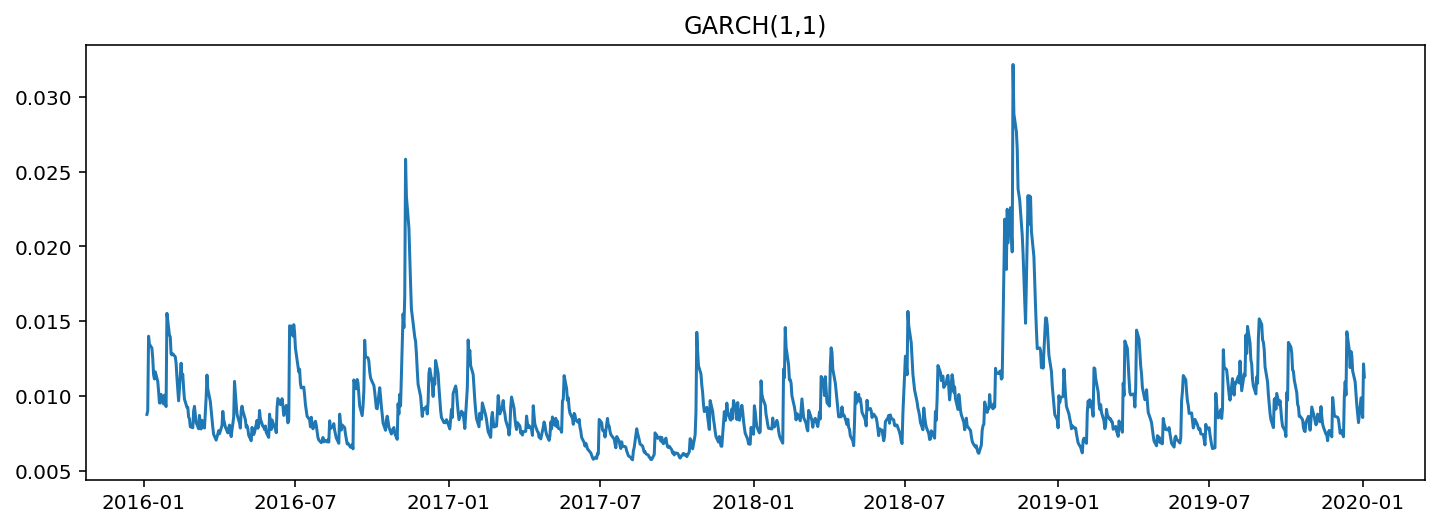

In [14]:
xaxis=R.index[1:]
sigma_garch=np.sqrt(garch_predict[1:])
plt.subplots(figsize=(12,4))
plt.title("GARCH(1,1)")
plt.plot(xaxis, sigma_garch);

# Modelo de volatilidad dinámica

$$
    \sigma_t^2 = (1-\lambda) r^2_{t-1} + \lambda \sigma_{t-1}^2
$$

In [26]:
# Como lambda es una palabra reservada en python, dejamos la variable cómo omega

class GARCHSigmas_lam:
    """
    Clase para estimar sigmas para un GARCH(1, 1)
    """
    def __init__(self, omega, sigma_init, R):
        self.omega = omega
        self.R = R
        self.sigma_hist = [sigma_init]
        self.initialize_sigmas()
        
    def get_sigma1(self, t):
        rt0 = 0 if t == 0 else self.R.iloc[t - 1, 0]
        sigma0 = self.sigma_hist[-1]
        # Aquí modificamos la variable
        sigma1 = (1-self.omega) * rt0 ** 2 + self.omega * sigma0
        self.sigma_hist.append(sigma1)
    
    def initialize_sigmas(self):
        N, M = self.R.shape
        for t in range(N - 1, -1, -1):
            self.get_sigma1(t)

In [27]:
def LGarch(omega, sigma_init, R):
    s=GARCHSigmas_lam(omega, sigma_init, R)
    sigma_hist=np.array(s.sigma_hist[1:])
    r1_2 =R.values.ravel()**2
    
    
    log_likelihood=(np.log(sigma_hist)+r1_2/sigma_hist).sum()/2
    return log_likelihood

In [28]:
seed(314)

omega = np.abs(randn())
sigma_init=R.var(ddof=1).item()/252
LGarch(omega, sigma_init, R)

/Users/danielpoblano/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: `item` has been deprecated and will be removed in a future version
  after removing the cwd from sys.path.


-1333.747975676454

In [29]:
omega

0.16608543874053203

In [30]:
x0=np.array([omega])
L_part=lambda x0: LGarch(x0,sigma_init,R)

#def cons(x):
#    return x[1]+x[2]-1
fmin=minimize(L_part, x0,bounds=[(0,1)])

In [31]:
fmin

      fun: -4574577.298184144
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.55879354])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 30
      nit: 9
   status: 0
  success: True
        x: array([0.97767149])